In [1]:
from helper import *
import helper

# Set random seed for reproducibility
seed_value = 5
set_random_seed(seed_value)

from sklearn.metrics import jaccard_score


from torchvision import transforms

# Applying the transform to an image (example)
from PIL import Image

torch.cuda.is_available()

True

In [2]:
data_dir = '/home/vs/Developer/obia-dl-ms-kerner-lab/neon-tree/neon-tree-rgb-label'

In [3]:
batch_size = 16 # set to 1 for test_loader
num_workers = 8 # matters if gpu idle, if gpu running
num_epochs = 10  # Set the number of epochs

In [4]:
# Define the transformation pipeline
image_transforms = transforms.Compose([
    transforms.Resize((512, 512)), 
    transforms.ToTensor(), 
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet's mean and std
])

label_transforms = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.NEAREST),  # Use nearest neighbor interpolation to keep label values intact
])

class nzCattleDataset(Dataset):
    """Custom Dataset for loading New Zealand Cattle data."""
    def __init__(self, data_dir, split, image_transform=None, label_transform=None):
        self.data_dir = data_dir
        self.image_transform = image_transform
        self.label_transform = label_transform

        with open(os.path.join(data_dir, 'default_partition.json')) as f:
            partition = json.load(f)[split]

        self.image_filenames = [f'{name}_image.png' for name in partition]
        self.label_filenames = [f'{name}_label.png' for name in partition]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image_path = os.path.join(self.data_dir, self.image_filenames[index])
        label_path = os.path.join(self.data_dir, self.label_filenames[index])

        image = Image.open(image_path)  # Ensure RGB format
        label = Image.open(label_path)

        if self.image_transform:
            image = self.image_transform(image)
        if self.label_transform:
            label = self.label_transform(label)
        
        # Convert to Tensors
        # image_t = torch.from_numpy(np.array(image)).permute(2, 0, 1).float()  # Assuming channels-first
        label_t = torch.from_numpy(np.array(label)).long().unsqueeze(0)  # Assuming channels-last
        
        return image, label_t

train_dataset = nzCattleDataset(data_dir, split='train', image_transform=image_transforms, label_transform=label_transforms)
val_dataset = nzCattleDataset(data_dir, split='valid', image_transform=image_transforms, label_transform=label_transforms)
test_dataset = nzCattleDataset(data_dir, split='test', image_transform=image_transforms, label_transform=label_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)



Images Batch shape: torch.Size([16, 3, 512, 512]), Labels Batch shape: torch.Size([16, 1, 512, 512])
Labels unique values: tensor([0, 1]), Labels min: 0, Labels max: 1
Image shape: torch.Size([3, 512, 512]), Label shape: torch.Size([1, 512, 512]), Image type: torch.float32, Label type: torch.int64
Label unique values: tensor([0, 1]), Label min: 0, Label max: 1


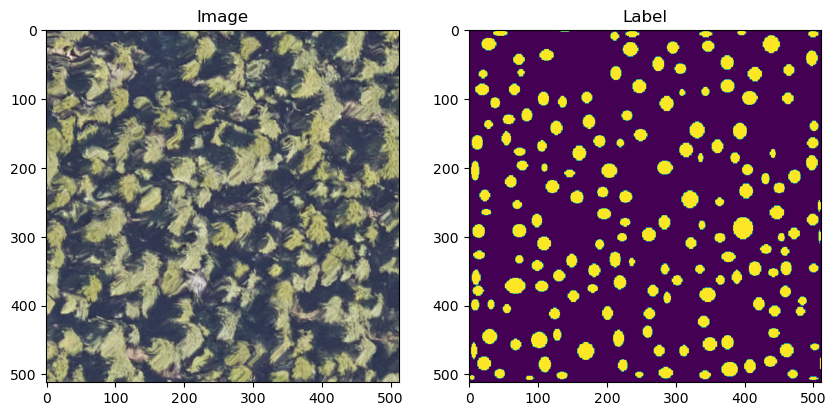

In [5]:
# Get a sample batch from the dataloader
for images, labels in train_loader:
    print(f"Images Batch shape: {images.shape}, Labels Batch shape: {labels.shape}")
    print(f"Labels unique values: {torch.unique(labels)}, Labels min: {torch.min(labels)}, Labels max: {torch.max(labels)}")

    image = images[0]
    label = labels[0]

    print(f"Image shape: {image.shape}, Label shape: {label.shape}, Image type: {image.dtype}, Label type: {label.dtype}")   
    print(f"Label unique values: {torch.unique(label)}, Label min: {torch.min(label)}, Label max: {torch.max(label)}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image.permute(1, 2, 0))
    ax1.set_title('Image')
    ax2.imshow(label.permute(1, 2, 0))
    ax2.set_title('Label')
    plt.show()

    break  # Exit the loop after plotting one sample

In [6]:
len(train_loader), len(val_loader), len(test_loader)

(17, 6, 6)

In [7]:
# Count the number of images and labels in the dataset
train_images, train_labels = count_images_and_labels(train_loader)
val_images, val_labels = count_images_and_labels(val_loader)
test_images, test_labels = count_images_and_labels(test_loader)

print(f"Train Dataloader: {train_images} images, {train_labels} labels")
print(f"Val Dataloader: {val_images} images, {val_labels} labels")
print(f"Test Dataloader: {test_images} images, {test_labels} labels")


Train Dataloader: 270 images, 270 labels
Val Dataloader: 94 images, 94 labels
Test Dataloader: 93 images, 93 labels


In [8]:
class SegmentationModel(nn.Module):
    def __init__(self, pretrained_path=None, fine_tune_start_layer=3):
        super(SegmentationModel, self).__init__()
        # Load a pretrained ResNet-50 without pretrained weights
        backbone = models.resnet50(pretrained=True)

        # if pretrained_path:
        #     state_dict = torch.load(pretrained_path, map_location='cpu')
        #     # If the state dict has the 'state_dict' key (common in training scripts), use the inner dict
        #     if 'state_dict' in state_dict:
        #         state_dict = {k.replace('module.', ''): v for k, v in state_dict['state_dict'].items()}
        #     backbone.load_state_dict(state_dict, strict=False)

        # Freeze the early layers
        for param in list(backbone.parameters())[:fine_tune_start_layer]:
            param.requires_grad = False

        # Remove the fully connected layer and the average pooling layer
        self.encoder = nn.Sequential(*list(backbone.children())[:-2])

        # Increase the output resolution by adding additional upsampling layers
        # Redesigning the decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),  # size becomes 2x of input (e.g., from 16x16 to 32x32)
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),   # size becomes 2x of input (e.g., from 32x32 to 64x64)
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),   # size becomes 2x of input (e.g., from 64x64 to 128x128)
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),   # size becomes 2x of input (e.g., from 128x128 to 256x256)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),    # size becomes 2x of input (e.g., from 256x256 to 512x512)
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1),  # 1x1 convolution to adjust channel dimension to 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
# pretrained_weights_path = './detconb_resnet50_imagenet300_torchvision.pth.tar'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SegmentationModel()
model.to(device)

/home/vs/miniconda3/envs/obia-dl/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vs/miniconda3/envs/obia-dl/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SegmentationModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): C

In [10]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-6):
        inputs = torch.sigmoid(inputs)  # Apply sigmoid to squash outputs to a [0,1] range
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice_coeff = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice_coeff


In [11]:
class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, ce_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.BCEWithLogitsLoss()  # This loss combines a Sigmoid layer and the BCELoss in one single class.
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight

    def forward(self, inputs, targets):
        dice_loss = self.dice_loss(inputs, targets)
        ce_loss = self.ce_loss(inputs, targets)
        return self.dice_weight * dice_loss + self.ce_weight * ce_loss


In [12]:
def iou_score(outputs, masks):
    # Apply sigmoid to convert logits to probabilities
    probs = torch.sigmoid(outputs)
    
    # Convert probabilities to binary predictions
    preds = (probs > 0.5).float()
    
    # Calculate Intersection (True Positives)
    intersection = (preds * masks).sum(dim=[2, 3])
    
    # Calculate Union: Predicted Positives + Actual Positives - Intersection
    union = ((preds + masks) > 0).float().sum(dim=[2, 3])
    
    # Initialize IoU tensor with zeros
    iou = torch.zeros_like(intersection)
    
    # Only calculate IoU for non-zero unions, to avoid division by zero
    nonzero_union = union > 0
    iou[nonzero_union] = intersection[nonzero_union] / union[nonzero_union]
    
    return iou


In [13]:
def precision_score(preds, labels):
    preds = torch.sigmoid(preds) > 0.5  # Converting logits to binary predictions (0 or 1)
    true_positive = torch.sum(preds * labels).float()
    predicted_positive = torch.sum(preds).float()
    precision = true_positive / (predicted_positive + 1e-8)  # Adding a small constant to avoid division by zero
    return precision


In [14]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
# criterion = CombinedLoss(dice_weight=0.7, ce_weight=0.3)  # More weight to Dice loss
criterion = DiceLoss()

In [15]:
dummy_input = torch.randn(1, 3, 500, 500).to(device)  # Simulate a single input image
output = model(dummy_input)
print(output.shape) 

torch.Size([1, 1, 512, 512])


In [16]:

# # Example training loop
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for images, masks in train_loader:
#         images = images.to(device)
#         masks = masks.to(device).float()
#         print(image.dtype, masks.dtype)

#         # Forward pass
#         outputs = model(images)
#         loss = criterion(outputs, masks)

#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

In [17]:
train_losses = []
val_losses = []
train_iou_scores = []
val_iou_scores = []
train_precision_scores = []
val_precision_scores = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    running_precision = 0.0
    
    train_loop = tqdm(train_loader, leave=True, position=0)
    for images, labels in train_loop:
        images = images.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        batch_iou = iou_score(outputs, labels).mean()
        batch_precision = precision_score(outputs, labels)
        running_iou += batch_iou.item()
        running_precision += batch_precision.item()
        
        train_loop.set_description(f'Epoch {epoch+1}/{num_epochs}')
        train_loop.set_postfix(loss=loss.item(), IoU=batch_iou.item(), Precision=batch_precision.item())
    
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    epoch_iou = running_iou / len(train_loader)
    train_iou_scores.append(epoch_iou)
    epoch_precision = running_precision / len(train_loader)
    train_precision_scores.append(epoch_precision)

    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    val_precision = 0.0
    val_loop = tqdm(val_loader, leave=True, position=0)
    with torch.no_grad():
        for images, labels in val_loop:
            images = images.to(device).float()
            labels = labels.to(device).float()
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            batch_iou_val = iou_score(outputs, labels).mean()
            batch_precision_val = precision_score(outputs, labels)
            val_iou += batch_iou_val.item()
            val_precision += batch_precision_val.item()
            
            val_loop.set_description('Validation')  
            val_loop.set_postfix(loss=loss.item(), IoU=batch_iou.item(), Precision=batch_precision_val.item())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_iou /= len(val_loader)
    val_iou_scores.append(val_iou)
    val_precision /= len(val_loader)
    val_precision_scores.append(val_precision)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Train IoU: {epoch_iou:.4f}, Val IoU: {val_iou:.4f}, Train Precision: {epoch_precision:.4f}, Val Precision: {val_precision:.4f}')


Validation: 100%|██████████| 6/6 [00:01<00:00,  4.57it/s, IoU=0.201, Precision=0.0953, loss=0.834]


Epoch 1/10, Train Loss: 0.7218, Val Loss: 0.8025, Train IoU: 0.1535, Val IoU: 0.1018, Train Precision: 0.1929, Val Precision: 0.1157


Validation: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s, IoU=0.289, Precision=0.354, loss=0.802]


Epoch 2/10, Train Loss: 0.6894, Val Loss: 0.7710, Train IoU: 0.2263, Val IoU: 0.1478, Train Precision: 0.2692, Val Precision: 0.3658


Validation: 100%|██████████| 6/6 [00:01<00:00,  4.94it/s, IoU=0.323, Precision=0.238, loss=0.641]


Epoch 3/10, Train Loss: 0.5837, Val Loss: 0.6341, Train IoU: 0.2761, Val IoU: 0.2069, Train Precision: 0.3652, Val Precision: 0.2513


Validation: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s, IoU=0.288, Precision=0.365, loss=0.642]


Epoch 4/10, Train Loss: 0.4811, Val Loss: 0.6550, Train IoU: 0.3091, Val IoU: 0.1631, Train Precision: 0.4384, Val Precision: 0.3911


Validation: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s, IoU=0.314, Precision=0.426, loss=0.621]


Epoch 5/10, Train Loss: 0.4518, Val Loss: 0.6132, Train IoU: 0.3187, Val IoU: 0.1654, Train Precision: 0.4886, Val Precision: 0.4327


Validation: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s, IoU=0.301, Precision=0.455, loss=0.568]


Epoch 6/10, Train Loss: 0.4253, Val Loss: 0.5907, Train IoU: 0.3420, Val IoU: 0.1555, Train Precision: 0.5140, Val Precision: 0.4418


Validation: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s, IoU=0.316, Precision=0.48, loss=0.593] 


Epoch 7/10, Train Loss: 0.4012, Val Loss: 0.6228, Train IoU: 0.3668, Val IoU: 0.1576, Train Precision: 0.5445, Val Precision: 0.5082


Validation: 100%|██████████| 6/6 [00:01<00:00,  4.69it/s, IoU=0.419, Precision=0.514, loss=0.551]


Epoch 8/10, Train Loss: 0.3784, Val Loss: 0.5830, Train IoU: 0.3881, Val IoU: 0.1715, Train Precision: 0.5780, Val Precision: 0.5233


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.12it/s, IoU=0.37, Precision=0.5, loss=0.561]  


Epoch 9/10, Train Loss: 0.3682, Val Loss: 0.5968, Train IoU: 0.4028, Val IoU: 0.1466, Train Precision: 0.5972, Val Precision: 0.5106


Validation: 100%|██████████| 6/6 [00:01<00:00,  4.74it/s, IoU=0.438, Precision=0.564, loss=0.595]

Epoch 10/10, Train Loss: 0.3373, Val Loss: 0.6481, Train IoU: 0.4357, Val IoU: 0.1312, Train Precision: 0.6303, Val Precision: 0.5702


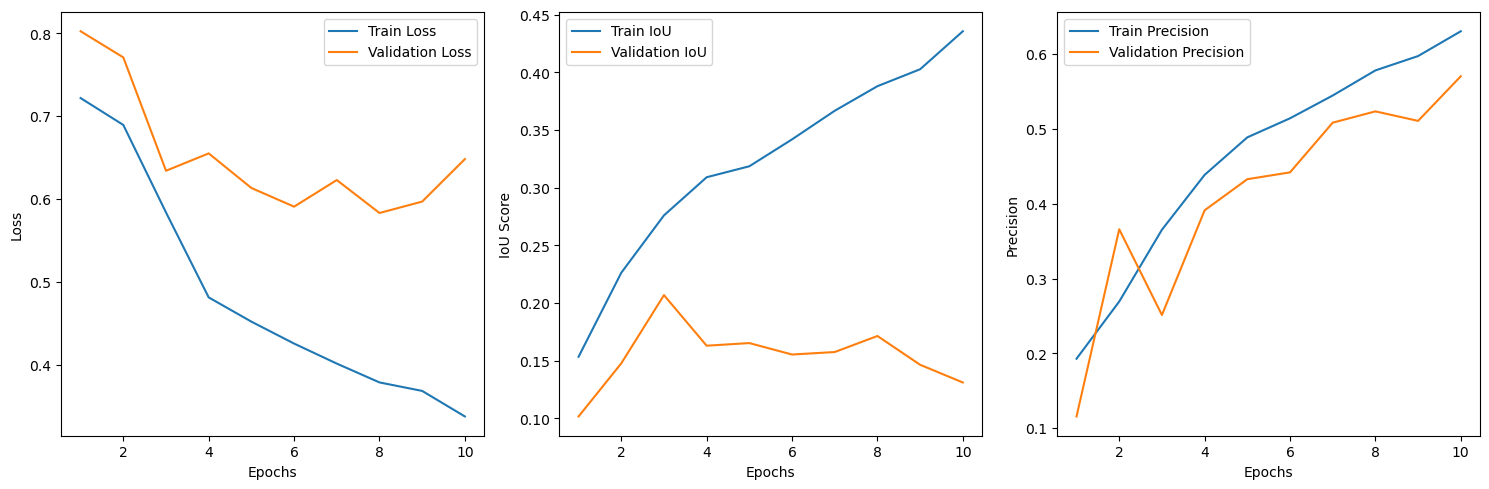

In [18]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), train_iou_scores, label='Train IoU')
plt.plot(range(1, num_epochs+1), val_iou_scores, label='Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), train_precision_scores, label='Train Precision')
plt.plot(range(1, num_epochs+1), val_precision_scores, label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
# Testing the final trained model
model.eval()
test_loss = 0.0
test_iou = 0.0
test_precision = 0.0
count = 0

# Wrap test_loader with tqdm for a progress bar
test_loop = tqdm(test_loader, leave=True, position=0)
with torch.no_grad():
    for images, masks in test_loop:
        images = images.to(device).float()
        masks = masks.to(device).float()
        outputs = model(images)

        loss = criterion(outputs, masks)
        test_loss += loss.item()

        batch_iou = iou_score(outputs, masks).mean()
        test_iou += batch_iou.item()

        batch_precision = precision_score(outputs, masks)
        test_precision += batch_precision.item()

        # Optional: Update tqdm description with loss, IoU, and precision
        test_loop.set_description('Test Evaluation')
        test_loop.set_postfix(loss=loss.item(), IoU=batch_iou.item(), Precision=batch_precision.item())

        
# Calculate the average loss, IoU, and precision over all test data
test_loss /= len(test_loader)
test_iou /= len(test_loader)
test_precision /= len(test_loader)

# Print the final results including precision
print(f'Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}, Test Precision: {test_precision:.4f}')


Test Evaluation: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s, IoU=0.121, Precision=0.589, loss=0.611] 

Test Loss: 0.6181, Test IoU: 0.1361, Test Precision: 0.5789
